# Demo 3

> Test Fast.ai models with a simple supervised learning test


In [1]:
# | default_exp demo.demo4

In [2]:
!gpustat

merlin                      Mon Nov  6 12:51:22 2023  535.113.01
[0] NVIDIA GeForce RTX 4090 | 38°C,   3 % |   973 / 24564 MB | biagio(390M) biagio(247M) biagio(153M)
[1] NVIDIA GeForce RTX 4090 | 38°C,   0 % |    16 / 24564 MB | biagio(4M)


In [3]:
#| hide
from nbdev.showdoc import *

%matplotlib inline
from fastai.vision.all import *
from fastai.data.all import *
import torch.nn.functional as F

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from Noise2Model.core import *

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [4]:
bs, size = 4, 512
# arch = models.resnet34
path = Path('../_data/Confocal_BPAE_B/')
path_train_raw = Path(path/"raw")
path_train_gt = Path(path/"gt")

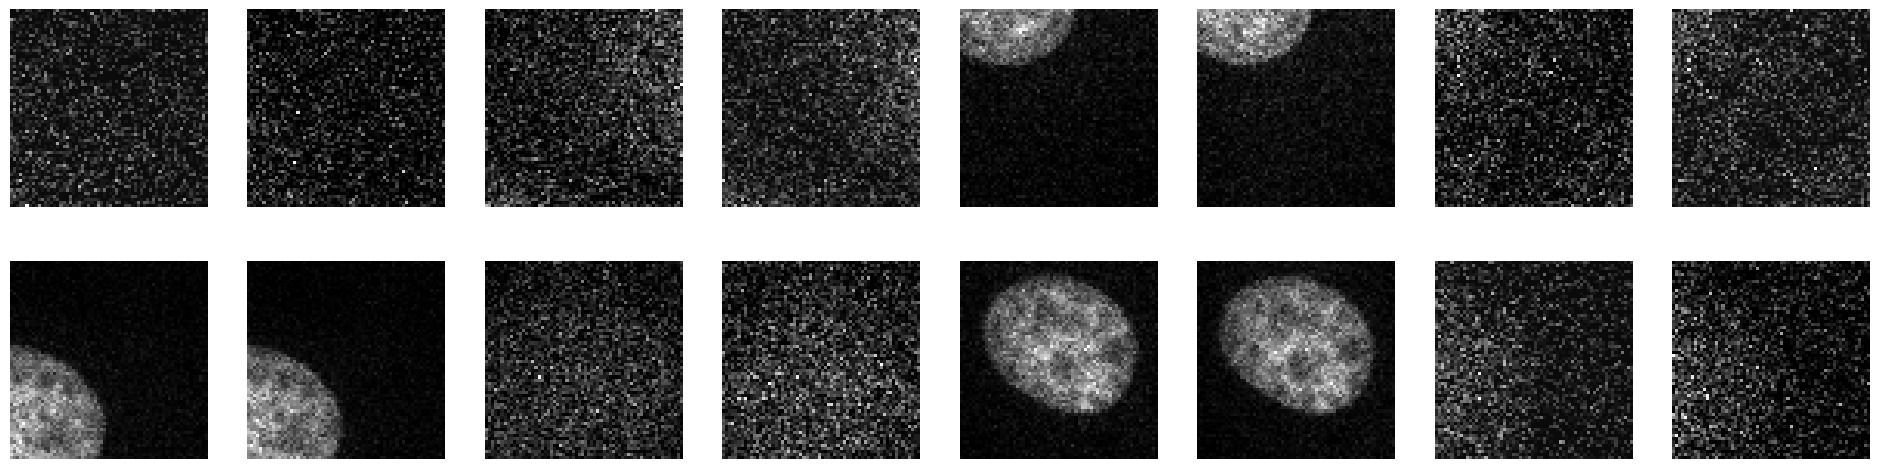

In [5]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
                   get_items=get_image_files,
                   get_y=get_noisy_pair,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=RandomCrop(64),
                   )
# dblock.summary(path_train_raw)
# dsets = dblock.datasets(path_train_raw)
# dsets.train[0]
dls = dblock.dataloaders(path_train_raw)
dls.show_batch(max_n=8, cmap='gray')

In [6]:
from Noise2Model.noise2noiseflow import Noise2NoiseFlow
from Noise2Model.models import UNet

# from Noise2Model.noiseflow import NoiseFlow

In [7]:
x,y = dls.one_batch()
x_shape = (x.shape)
net = Noise2NoiseFlow(x_shape[1:], arch='gain', denoiser=UNet(3), lmbda=0.5)
# net = NoiseFlow(x.shape, arch='unc')
# z, objective, denoised = net.forward(x.to('cpu'))
# test_eq(denoised.shape, x.shape)

|-Gain


In [8]:
def SymmetricLoss(noisy1:Tensor, noisy2:Tensor) -> Tensor:
        denoised1 = learn.denoise(noisy1, clip=False)
        denoised2 = learn.denoise(noisy2, clip=False)

        mse_loss1 = learn.denoiser_loss(denoised1, noisy2)
        mse_loss2 = learn.denoiser_loss(denoised2, noisy1)
        # mse_loss1 = F.l1_loss(denoised1, noisy2)
        # mse_loss2 = F.l1_loss(denoised2, noisy1)

        denoised1 = torch.clamp(denoised1, 0., 1.)
        denoised2 = torch.clamp(denoised2, 0., 1.)
        
        noise1 = noisy1 - denoised2
        noise2 = noisy2 - denoised1

        # kwargs.update({'clean' : denoised2})
        nll1, _ = learn.noise_flow.loss(noise1, clean=denoised2)

        # kwargs.update({'clean' : denoised1})
        nll2, _ = learn.noise_flow.loss(noise2, clean=denoised1)

        nll = (1 - learn.lmbda) * (nll1 + nll2) / 2
        mse_loss = learn.lmbda * (mse_loss1 + mse_loss2) / 2

        return nll + mse_loss


In [9]:
learn = Learner(dls, net, loss_func=SymmetricLoss)
learn.summary()

Noise2NoiseFlow (Input shape: 64 x 1 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 64 x 64   
Conv2d                                    288        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 32 x 32   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 32 x 32   
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                            

In [10]:
# learn.show_training_loop()

SuggestedLRs(valley=0.0012022644514217973)

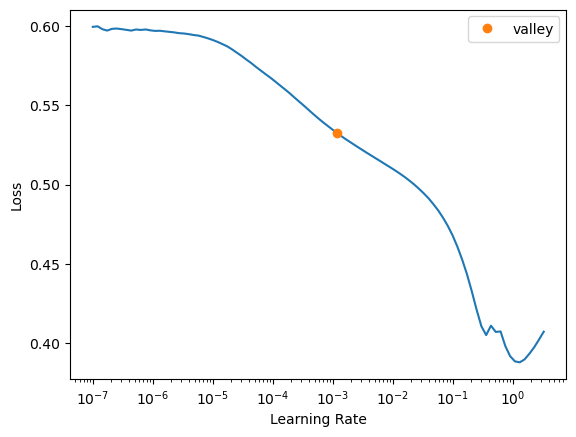

In [11]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(10, lr_max=5e-02) #cbs=ShowGraphCallback()

epoch,train_loss,valid_loss,time
0,-0.044040,0.030487,00:08
1,-0.035018,0.030954,00:08
2,-0.032174,0.018099,00:08
3,-0.028457,0.024750,00:08
4,-0.026036,0.024994,00:08
5,-0.030987,0.040169,00:08
6,-0.025558,0.029835,00:08
7,-0.024188,0.025232,00:08
8,-0.023244,0.024202,00:08
9,-0.027196,0.024061,00:08


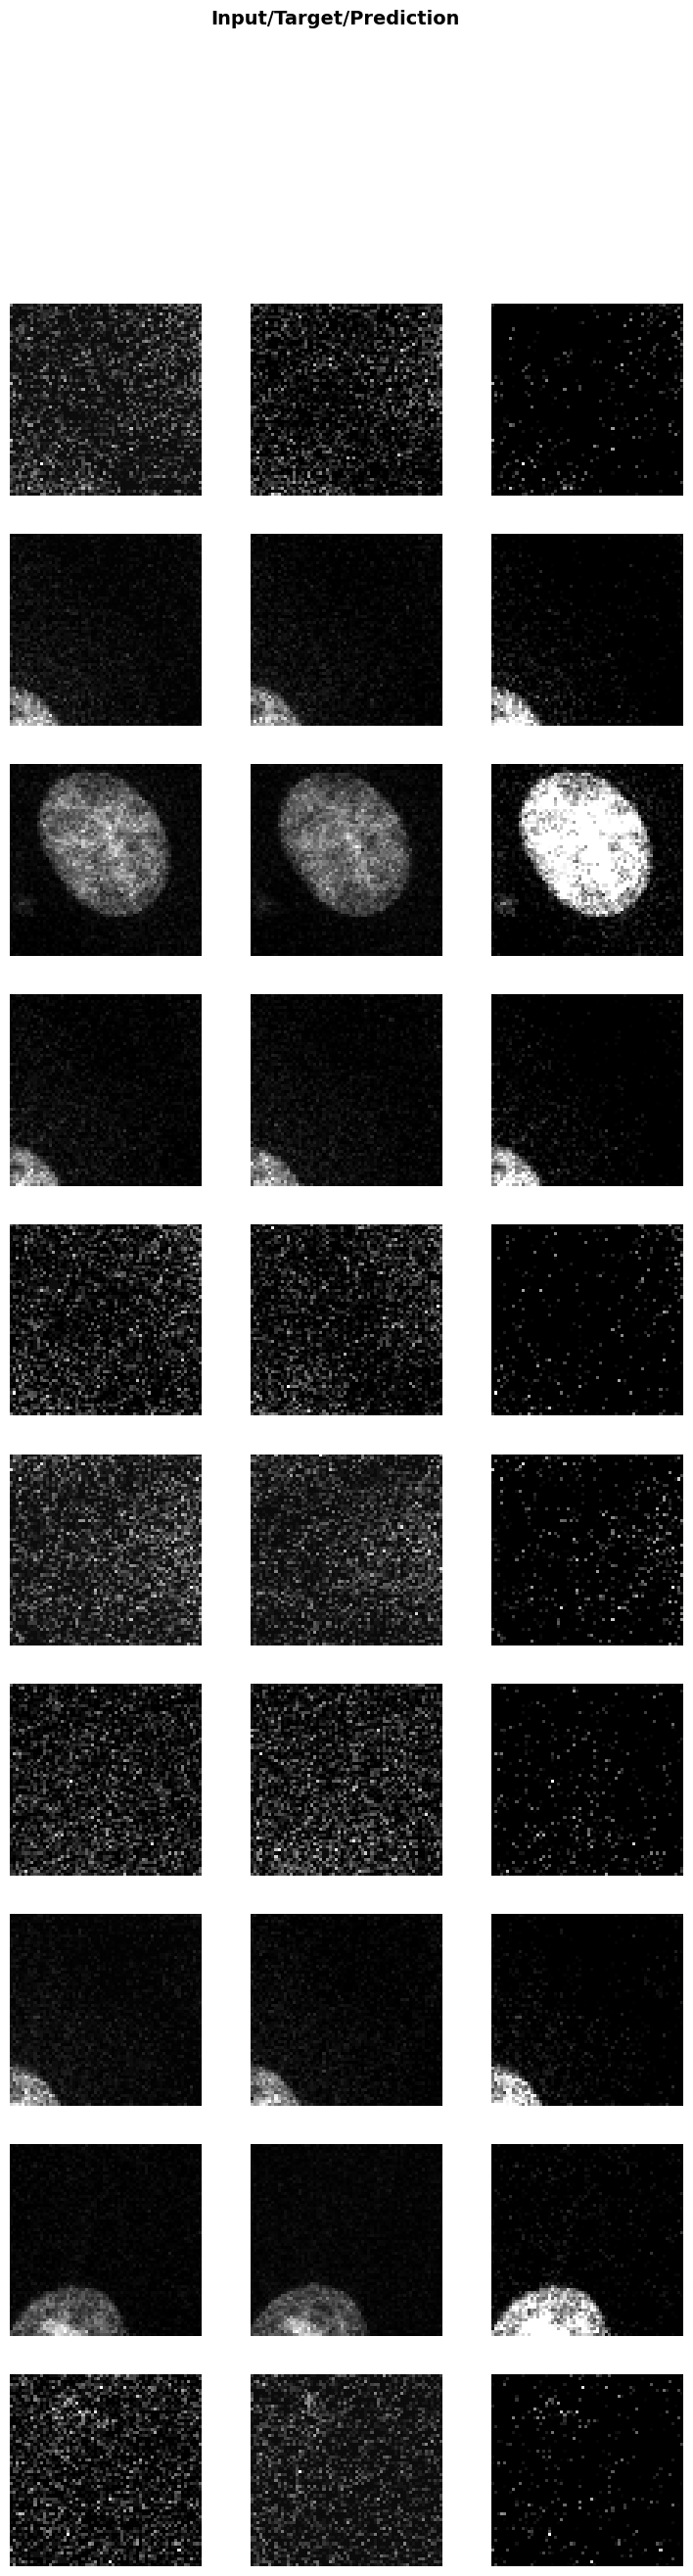

In [16]:
learn.show_results(max_n=10, cmap='gray')

In [17]:
# | hide
import nbdev
nbdev.nbdev_export()